In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import ShuffleSplit
import xgboost as xgb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt
import seaborn as sns

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv
/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv
/kaggle/input/equity-post-HCT-survival-predictions/train.csv
/kaggle/input/equity-post-HCT-survival-predictions/test.csv
/kaggle/input/pip-install-lifelines/fonttools-4.55.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/pip-install-lifelines/tzdata-2024.2-py2.py3-none-any.whl
/kaggle/input/pip-install-lifelines/kiwisolver-1.4.7-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
/kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
/kaggle/input/pip-install-lifelines/scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/pip-install-lifelines/pillow-11.0.0-cp310-cp310-manylinux_2_28_x86_64.whl
/kaggle/input/pip-install-lifelines/contourpy-1.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/pip-install-lifelines/pyparsing-3.2.0-py3-non

# **Competition Overview**

In this competition, you’ll develop models to improve the prediction of transplant survival rates for patients undergoing allogeneic Hematopoietic Cell Transplantation (HCT) — an important step in ensuring that every patient has a fair chance at a successful outcome, regardless of their background.

**I will continue to work on and update this notebook. Please upvote it if you find it useful in this interesting challenge!**

# **Loading Data and Initial EDA**

We will start by loading the data and performing initial exploratory data analysis (**EDA**).

In [2]:
train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
train

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,28795,Intermediate - TED AML case <missing cytogenetics,NaN,Favorable,No,2.0,8.0,No TBI,No,6.0,...,Bi-directional non-permissive,NaN,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,18.633
28796,28796,High,No,Poor,Yes,1.0,4.0,No TBI,No,5.0,...,GvH non-permissive,Related,"N/A, Mel not given",6.0,Yes,1.0,Yes,8.0,1.0,4.892
28797,28797,TBD cytogenetics,NaN,Poor,NaN,2.0,8.0,No TBI,NaN,6.0,...,GvH non-permissive,Unrelated,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,23.157
28798,28798,N/A - non-malignant indication,No,Poor,No,1.0,4.0,No TBI,No,3.0,...,Permissive mismatched,Related,MEL,4.0,No,1.0,No,5.0,0.0,52.351


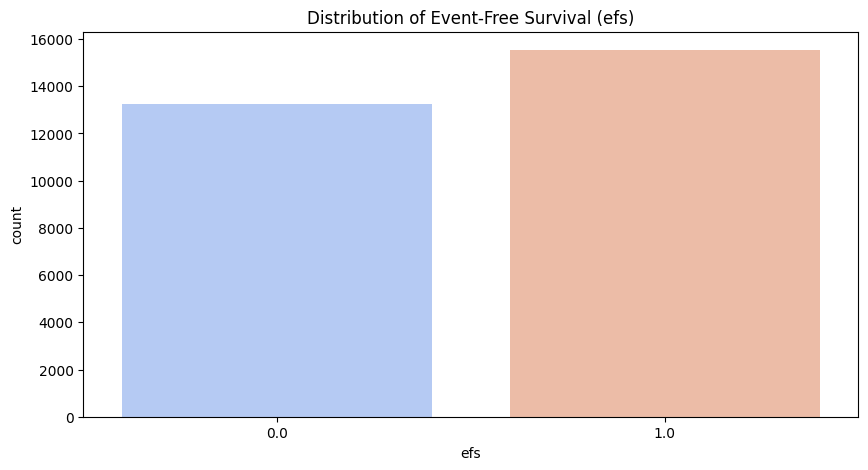

In [3]:
# Check the distribution of the target variables
plt.figure(figsize=(10, 5))
sns.countplot(data=train, x='efs', palette='coolwarm')
plt.title('Distribution of Event-Free Survival (efs)')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


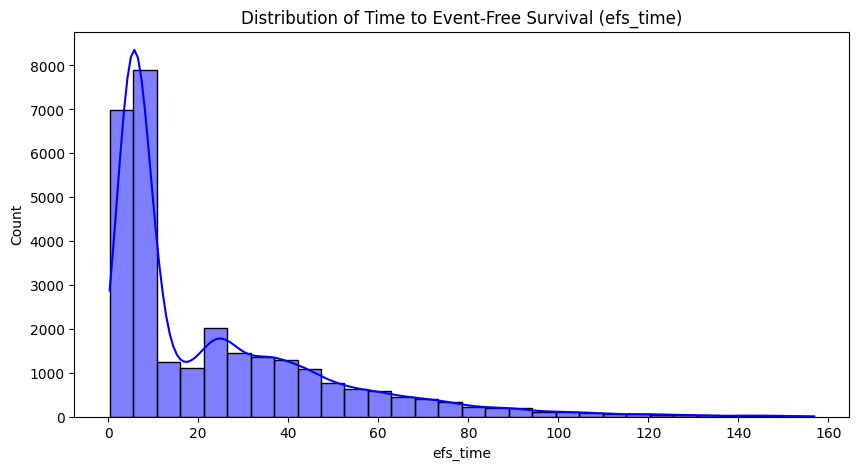

In [4]:
plt.figure(figsize=(10, 5))
sns.histplot(data=train, x='efs_time', bins=30, kde=True, color='blue')
plt.title('Distribution of Time to Event-Free Survival (efs_time)')
plt.show()

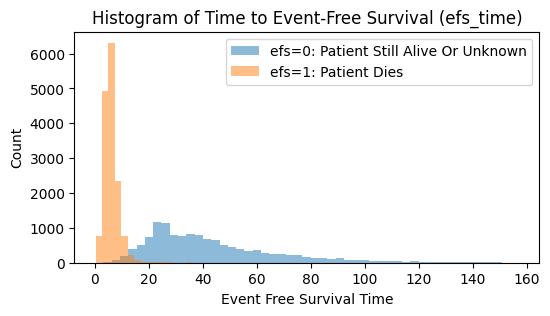

In [5]:
plt.figure(figsize=(6, 3))
plt.hist(train.efs_time[train.efs == 0], bins=50, label='efs=0: Patient Still Alive Or Unknown', alpha=0.5)
plt.hist(train.efs_time[train.efs == 1], bins=50, label='efs=1: Patient Dies', alpha=0.5)
plt.legend()
plt.xlabel('Event Free Survival Time')
plt.ylabel('Count')
plt.title('Histogram of Time to Event-Free Survival (efs_time)')
plt.show()

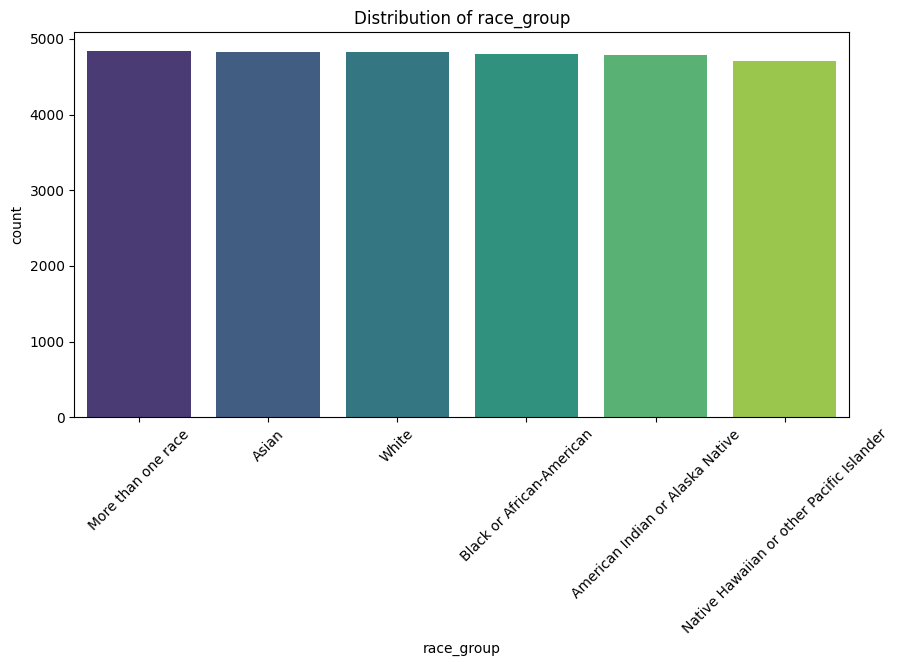

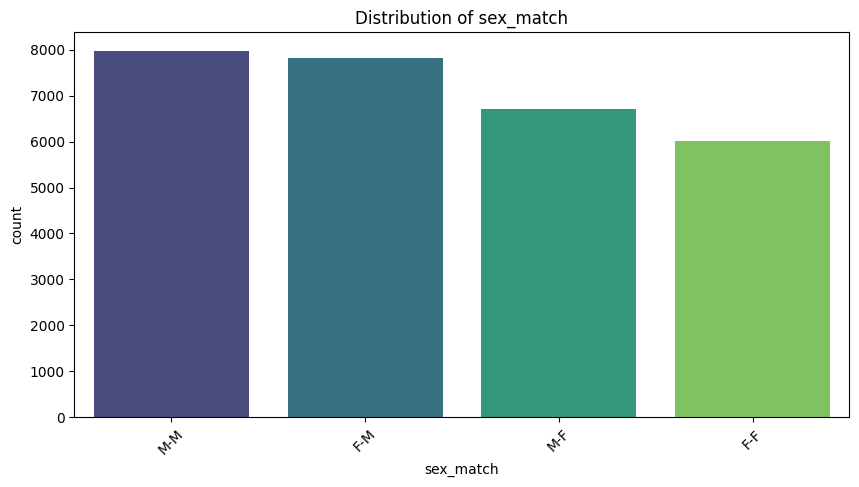

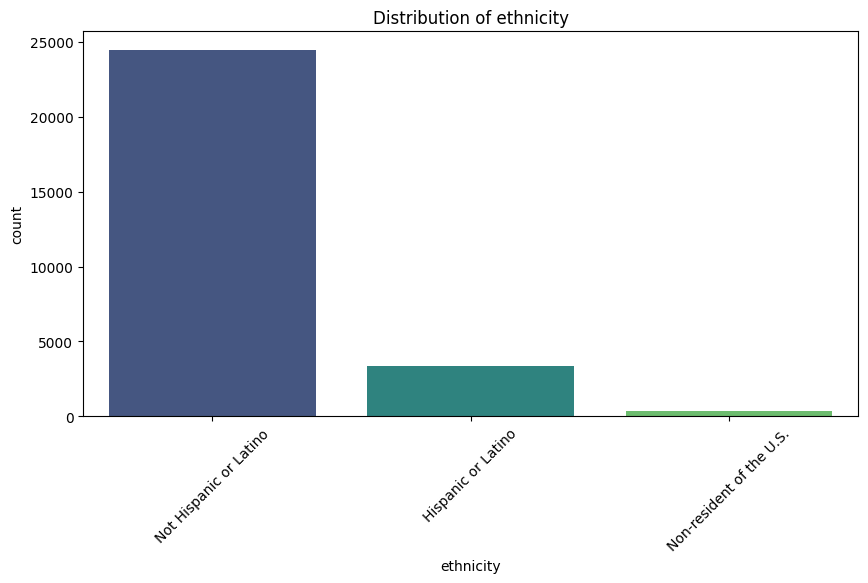

In [6]:
# Explore distribution of key demographic features
demo_features = ['race_group', 'sex_match', 'ethnicity']
for feature in demo_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=train, x=feature, palette='viridis', order=train[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.show()

In [7]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... - done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=1c20f35a9fcab00bc4041240d83c31a5234b12a46e75601403300710c98bf827
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


# **Kaplan-Meier Estimator**

The Kaplan-Meier Estimator is a non-parametric statistical method used in survival analysis to estimate the survival function from time-to-event data. It calculates the probability that an individual will survive beyond a certain point in time, accounting for censored data (cases, where the event of interest has not occurred by the end of the study or the individual, is lost to follow-up).

**Key Concepts:**

* **Survival Function ($S(t)$):**
    Represents the probability that a subject survives longer than a given time $t$.
    Mathematically:
    $$S(t) = P(T > t)$$
    where $T$ is the time to the event.
* **Event:**
    The occurrence of the event of interest (e.g., death, relapse, failure).
* **Censoring:**
    Happens when the full survival time is unknown.

**How It Works:**

The Kaplan-Meier estimator calculates the survival probability as a step function, updating probabilities at each event time. The formula for the survival function at time $t$ is:

$$S(t) = \prod_{t_i \leq t} (1 - \frac{d_i}{n_i})$$

Where:

* $t_i$: Times at which events occur.
* $d_i$: Number of events (e.g., deaths) at $t_i$.
* $n_i$: Number of individuals "at risk" just before $t_i$.

**Step-by-Step:**
1. Sort the data by time.
2. At each time $t_i$ where an event occurs:
    - Compute the probability of surviving past $t_i$: $1 - \frac{d_i}{n_i}$.
3. Multiply the survival probabilities sequentially to get the cumulative survival probability.

**Key Properties:**
* The Kaplan-Meier curve is a step function, with drops occurring at times when events are observed.
* It handles censoring by only considering individuals at risk just before each event time.

**Advantages:**
* Non-parametric: Makes no assumptions about the distribution of survival times.
* Handles Censoring: Incorporates censored data effectively.
* Easy Interpretation: Provides intuitive survival probabilities.

**Limitations:**
* Assumes Independence of Censoring: Assumes that the censored individuals have the same survival prospects as those still under observation.
* Lack of Multivariable Adjustments: Does not account for the effects of covariates (e.g., age, race). For this, models like Cox regression are used.
* Uncertainty at Long Times: If few individuals remain at risk at later time points, the estimates may become less reliable.

**Use Case:**

In the context of HCT survival analysis:

* Kaplan-Meier can estimate survival probabilities for the entire population or subgroups (e.g., race or gender).
* It helps visualize differences in survival rates among groups, providing insights into disparities or the impact of certain factors.

# **Kaplan-Meier Results**

The **Kaplan-Meier** survival curve represents the probability of remaining event-free (e.g., alive or without relapse) over time, with the y-axis showing survival probability and the x-axis representing time in months. Initially, the curve starts at 1.0 (100% survival) since all individuals are event-free at time zero. The steep decline in the early months indicates that a significant number of patients experience events, such as death or relapse, shortly after the transplant. This highlights the high-risk nature of the initial post-transplant period.

As time progresses, the curve begins to level off, particularly after 20-30 months, suggesting that those who survive the initial phase tend to have better long-term outcomes. The survival probability never reaches zero, indicating that a portion of the population remains event-free throughout the observation period. The shaded region around the curve represents the confidence interval, which reflects the uncertainty of the survival estimates. Early on, the confidence intervals are narrow, indicating precise estimates due to a larger sample size. However, they widen at later time points, reflecting fewer patients being observed (due to censoring), which reduces the precision of the estimates.

Overall, the **Kaplan-Meier** curve provides insight into the time-dependent risks of events, emphasizing the need for targeted interventions during the early post-transplant period to improve survival outcomes. The curve also suggests that patients who pass the high-risk early phase may achieve more favorable long-term survival. Further analysis, such as stratifying the data by race or comorbidity scores, could provide deeper insights into factors influencing survival and potential disparities across subgroups.

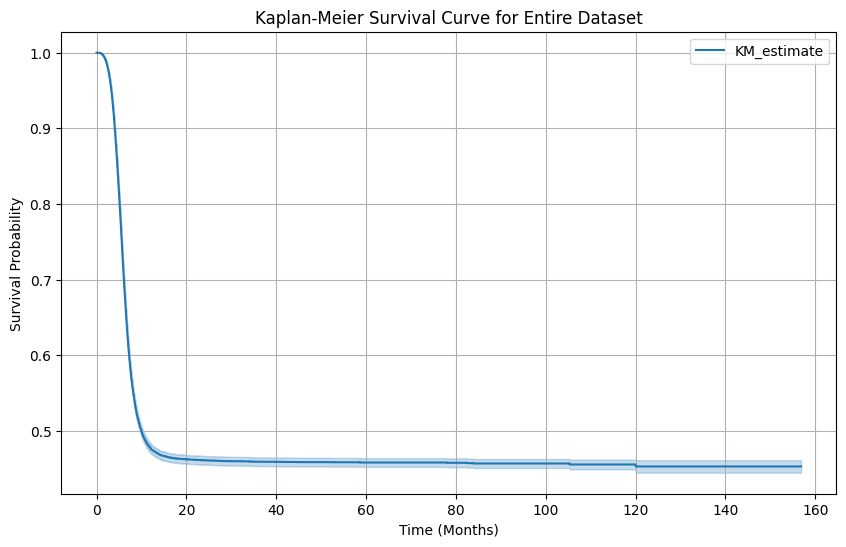

In [8]:
from lifelines import KaplanMeierFitter

# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Kaplan-Meier fit for the entire dataset
plt.figure(figsize=(10, 6))
kmf.fit(durations=train['efs_time'], event_observed=train['efs'])
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve for Entire Dataset')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.grid()
plt.show()

**Kaplan-Meier Survival Curve: Stratified by Race**

The Kaplan-Meier survival curve below visualizes the survival probabilities for different racial groups over time. Each line represents a specific race group. The shaded areas around the curves represent confidence intervals.

**Key Observations:**

* **Early Survival Decline:**
    * All race groups show a steep initial decline in survival probability, indicating a high risk of adverse events shortly after transplantation.
    * The rate of decline varies among groups, suggesting potential disparities in early survival outcomes.
* **Group Differences in Long-Term Survival:**
    * Groups like "More than one race" and "Asian" exhibit higher long-term survival probabilities compared to "White" and "Black or African-American" groups.
    * "American Indian or Alaska Native" and "Native Hawaiian or other Pacific Islander" groups show moderate survival probabilities.
* **Confidence Intervals:**
    * Confidence intervals widen over time, reflecting reduced sample sizes.
    * Widening is more pronounced in smaller racial groups, indicating greater uncertainty in survival estimates.
* **Potential Disparities:**
    * The observed differences in survival probabilities suggest disparities in post-transplant outcomes that may be influenced by various factors.
    * "White" and "Black or African-American" groups consistently have lower survival probabilities, highlighting areas for potential intervention.

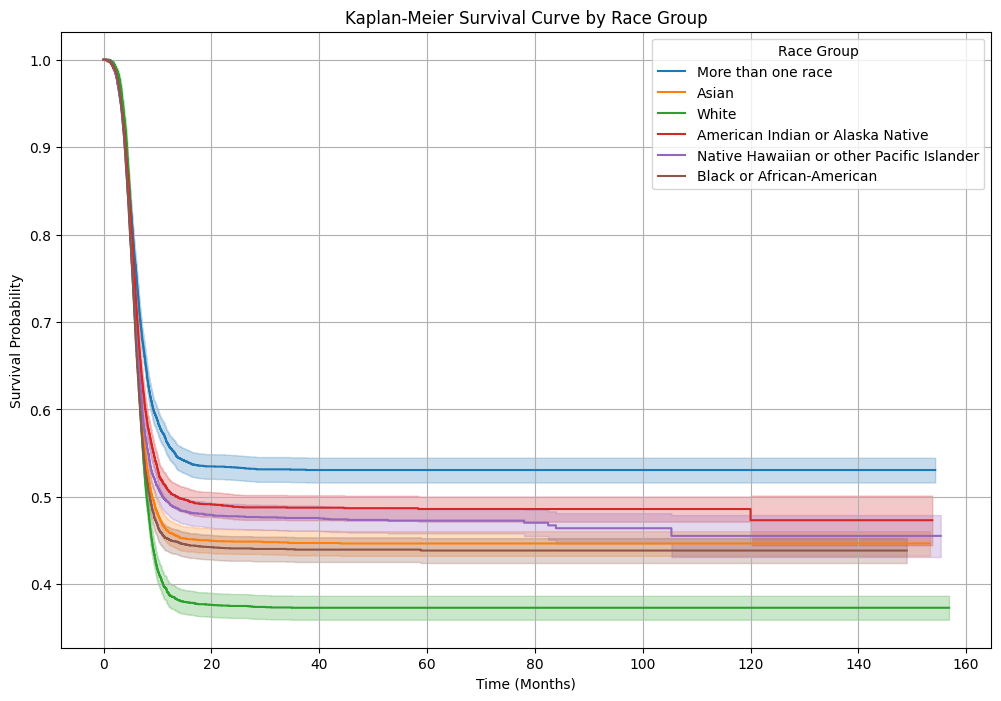

In [9]:
# Kaplan-Meier fit for different groups (e.g., race_group)
plt.figure(figsize=(12, 8))
for group in train['race_group'].dropna().unique():
    group_data = train[train['race_group'] == group]
    kmf.fit(durations=group_data['efs_time'], event_observed=group_data['efs'], label=group)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve by Race Group')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.legend(title='Race Group')
plt.grid()
plt.show()

**Kaplan-Meier Survival Curve: Stratified by Donor/Recipient Sex Match**

The Kaplan-Meier survival curve below visualizes the survival probabilities for different donor/recipient sex match combinations over time. Each curve represents one of the four possible combinations:

* Male-to-Female (M-F)
* Female-to-Female (F-F)
* Female-to-Male (F-M)
* Male-to-Male (M-M)

The shaded areas around the curves indicate confidence intervals.

**Key Observations:**

* **Early Decline in Survival:**
    * All groups show a steep initial decline in survival probability, reflecting the high-risk post-transplant period.
* **Long-Term Survival Differences:**
    * F-F and M-M show the highest long-term survival probability.
    * F-M and M-F have lower long-term survival probabilities.
* **Confidence Intervals:**
    * Confidence intervals widen over time, particularly for M-F and F-M.
    * F-F has relatively narrow intervals.

**Sex Match Impact:**

* F-F and M-M transplants tend to have better outcomes.
* M-F and F-M groups have lower survival probabilities.

**Insights and Implications:**

* **Clinical Relevance:**
    * The survival advantage for F-F and M-M may reflect better immunological compatibility.
    * M-F and F-M groups might benefit from additional clinical interventions.
* **Biological Factors:**
    * Differences in survival may stem from biological factors like immunological response or GVHD risk.
* **Further Analysis:**
    * Additional factors should be analyzed alongside sex match.
    * Statistical tests can confirm the significance of observed differences.

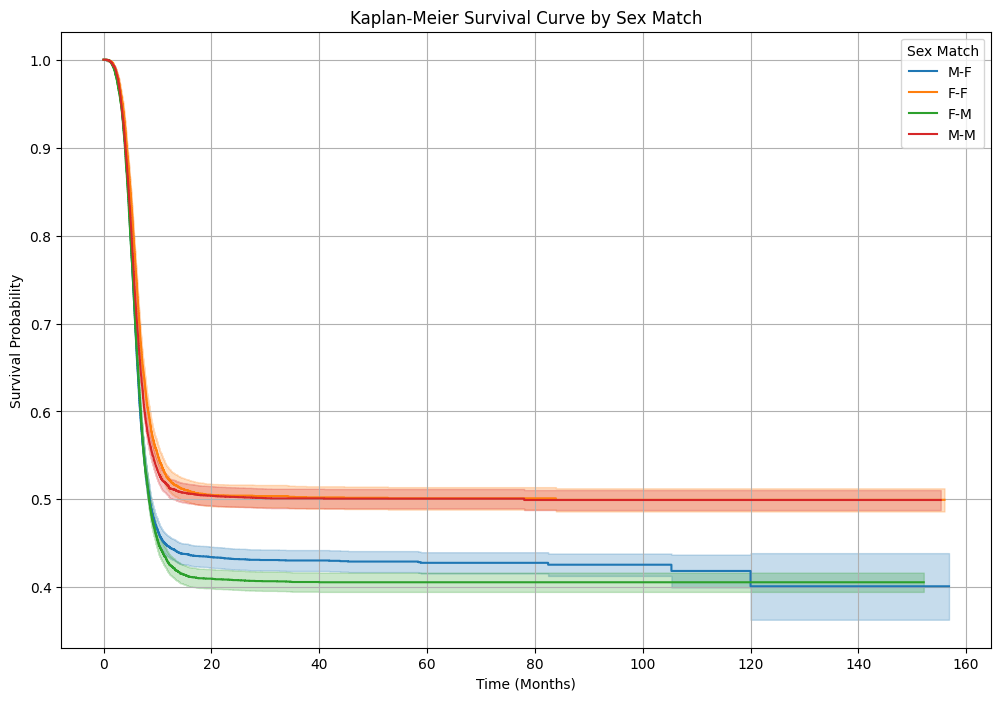

In [10]:
# Kaplan-Meier fit for a binary feature (e.g., gender)
plt.figure(figsize=(12, 8))
for gender in train['sex_match'].dropna().unique():
    gender_data = train[train['sex_match'] == gender]
    kmf.fit(durations=gender_data['efs_time'], event_observed=gender_data['efs'], label=gender)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve by Sex Match')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.legend(title='Sex Match')
plt.grid()
plt.show()

# **Cox Proportional Hazards (CPH) Model**

The **Cox Proportional Hazards (CPH) model** is a widely used method in survival analysis for evaluating the effect of multiple covariates on the time to a specific event, such as death or relapse. Unlike non-parametric methods like Kaplan-Meier, CPH is a semi-parametric model incorporating covariates to estimate their influence on survival while making no assumptions about the baseline hazard function.

---

**Key Concepts**

### 1. **Hazard Function**

The CPH model is based on the **hazard function**, which represents the instantaneous rate at which an event occurs at time $t$, given survival up to that time. The hazard function is defined as:

$$
h(t | X) = h_0(t) \cdot \exp(\beta_1 X_1 + \beta_2 X_2 + \ldots + \beta_p X_p)
$$

Where:
- $h(t | X)$: The hazard function at time $t$, conditional on covariates $X$.
- $h_0(t)$: The baseline hazard function, which is unspecified (non-parametric).
- $\exp(\beta_1 X_1 + \ldots + \beta_p X_p)$: A multiplicative factor that models the effect of covariates $X_1, X_2, \ldots, X_p$ on the hazard.

---

### 2. **Proportional Hazards Assumption**

The model assumes that the ratio of hazards between two individuals is constant over time, regardless of $h_0(t)$. This is known as the **proportional hazards assumption**.

For two individuals with covariates $X^{(1)}$ and $X^{(2)}$, the ratio of their hazards is:

$$
\frac{h(t | X^{(1)})}{h(t | X^{(2)})} = \exp\left(\beta_1 (X_1^{(1)} - X_1^{(2)}) + \ldots + \beta_p (X_p^{(1)} - X_p^{(2)})\right)
$$

This ratio is time-independent, which is a key property of the Cox model.

---

### 3. **Coefficients ($\beta$)**

- Each covariate $X_i$ in the model has an associated coefficient $\beta_i$, which quantifies the relationship between the covariate and the hazard.
- The **hazard ratio (HR)** is defined as:

$$
\text{HR} = \exp(\beta_i)
$$

  - $\text{HR} > 1$: The covariate increases the hazard (higher risk).
  - $\text{HR} < 1$: The covariate decreases the hazard (lower risk).
  - $\text{HR} = 1$: The covariate has no effect on the hazard.

---

### 4. **Baseline Hazard ($h_0(t)$)**

The baseline hazard $h_0(t)$ represents the hazard when all covariates are zero. The Cox model does not estimate $h_0(t)$ explicitly, as it focuses on the relative effect of covariates on the hazard.

---

### 5. **Censoring**

The Cox model accounts for right-censored data, where the event of interest has not occurred by the end of the study or the individual is lost to follow-up. Censoring is incorporated into the likelihood function, ensuring unbiased estimates.

---

**Steps in Analysis**

### 1. **Variable Selection**

- Choose relevant covariates (predictors) based on domain knowledge or exploratory analysis.
- Encode categorical variables (e.g., race group) as dummy variables.

### 2. **Model Fitting**

- The model estimates the coefficients $\beta_i$ by maximizing the **partial likelihood**, which considers the ordering of event times rather than their absolute values.

### 3. **Model Summary**

The output includes:
- **Coefficients ($\beta$)**: Quantifies the effect of covariates on the hazard.
- **Hazard Ratios ($\exp(\beta)$)**: Indicates the relative risk.
- **P-values**: Tests the statistical significance of each covariate.
- **Confidence Intervals (CIs)**: Provides a range for the true hazard ratio.

---

**Interpretation**

1. A covariate with a significant p-value and $\text{HR} > 1$ increases the risk of the event.
2. A covariate with $\text{HR} < 1$ decreases the risk of the event, indicating a protective effect.
3. Non-significant covariates (high p-values) have no strong evidence of association with survival.

---

**Benefits**

- **Multivariable Analysis**: Simultaneously evaluates the effect of multiple covariates.
- **Flexibility**: Makes no assumptions about the baseline hazard function.
- **Interpretability**: Provides hazard ratios, which are intuitive to understand.

---

**Limitations**

1. **Proportional Hazards Assumption**:
   - The model assumes the hazard ratio between individuals is constant over time. Violations of this assumption can bias results.
2. **Linearity of Covariates**:
   - Assumes a linear relationship between covariates and the log-hazard. Nonlinear effects require transformations or more advanced models.

---

In [11]:
train

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,28795,Intermediate - TED AML case <missing cytogenetics,NaN,Favorable,No,2.0,8.0,No TBI,No,6.0,...,Bi-directional non-permissive,NaN,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,18.633
28796,28796,High,No,Poor,Yes,1.0,4.0,No TBI,No,5.0,...,GvH non-permissive,Related,"N/A, Mel not given",6.0,Yes,1.0,Yes,8.0,1.0,4.892
28797,28797,TBD cytogenetics,NaN,Poor,NaN,2.0,8.0,No TBI,NaN,6.0,...,GvH non-permissive,Unrelated,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,23.157
28798,28798,N/A - non-malignant indication,No,Poor,No,1.0,4.0,No TBI,No,3.0,...,Permissive mismatched,Related,MEL,4.0,No,1.0,No,5.0,0.0,52.351


In [12]:
from lifelines import CoxPHFitter

# Preprocess data
# Select relevant columns for Cox regression
cox_features = ['efs_time', 'efs', 'age_at_hct', 'karnofsky_score', 'comorbidity_score', 'race_group']
train = train[cox_features]

# Convert categorical variables into dummy variables
train = pd.get_dummies(train, columns=['race_group'], drop_first=True)

# Drop rows with missing values (ensure clean data for Cox model)
train = train.dropna()

# Instantiate and fit the Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(train, duration_col='efs_time', event_col='efs')

# Show summary of the model
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 27472 total observations, 12560 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 27472
number of events observed = 14912
   partial log-likelihood = -146244.09
         time fit was run = 2024-12-13 19:37:40 UTC

---
                                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                             
age_at_hct                                            0.01      1.01      0.00            0.01            0.01                1.01                1.01
karnofsky_score                                      -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
comorbidity_score                                     0.09      1.09      0.00            0.08            0.10                1.09                1.10
race_group_Asian                                      0.05      1.05      0.03           -0.01            0.10                0.99                1.11
race_group_Black or African-American                  0.20      1.22      0.03            0.15            0.26                1.16                1.29
race_group_More than one race                        -0.10      0.91      0.03           -0.16           -0.04                0.85                0.96
race_group_Native Hawaiian or other Pacific Islander  0.02      1.02      0.03           -0.04            0.08                0.96                1.08
race_group_White                                      0.19      1.21      0.03            0.14            0.25                1.15                1.28

                                                      cmp to     z      p  -log2(p)
covariate                                                                          
age_at_hct                                              0.00 26.47 <0.005    510.63
karnofsky_score                                         0.00 -9.73 <0.005     71.91
comorbidity_score                                       0.00 22.46 <0.005    368.56
race_group_Asian                                        0.00  1.63   0.10      3.28
race_group_Black or African-American                    0.00  7.04 <0.005     38.91
race_group_More than one race                           0.00 -3.29 <0.005      9.95
race_group_Native Hawaiian or other Pacific Islander    0.00  0.74   0.46      1.12
race_group_White                                        0.00  6.94 <0.005     37.91
---
Concordance = 0.60
Partial AIC = 292504.18
log-likelihood ratio test = 2081.88 on 8 df
-log2(p) of ll-ratio test = inf

# **Analysis of CPH Results**

The hazard ratio (HR) plot illustrates the effects of different covariates on the hazard of the event occurring, as estimated by the Cox Proportional Hazards model. The x-axis represents the hazard ratio, where a value of 1.0 (marked by the dashed vertical line) indicates no effect on the hazard. Hazard ratios greater than 1.0 indicate an increased risk of the event, while values less than 1.0 suggest a protective effect or reduced risk. The 95% confidence intervals (CIs) are shown as horizontal lines around each hazard ratio, indicating the uncertainty in the estimates. If a confidence interval crosses 1.0, the effect of the covariate is not statistically significant.

The analysis reveals several key findings. Among race groups, **"Black or African-American"** and **"White"** have hazard ratios slightly above 1.0, indicating a marginally increased risk compared to the reference group (likely another race, such as **"Asian"** or **"More than one race"**). Conversely, the **"More than one race"** group has an HR less than 1.0, suggesting a protective effect, while **"Native Hawaiian or other Pacific Islander"** shows little to no impact on the hazard. The **comorbidity score** has an HR slightly above 1.0, indicating that patients with more comorbidities are at greater risk of the event. Similarly, **"age at HCT"** has a hazard ratio above 1.0, suggesting that older patients face a slightly higher risk. In contrast, the **Karnofsky performance score** has a hazard ratio less than 1.0, reflecting a protective effect where higher scores (indicating better performance status) are associated with reduced risk.

Statistical significance can be inferred from the confidence intervals. Covariates such as **comorbidity score** and **Karnofsky score** likely have statistically significant effects, as their confidence intervals do not cross 1.0. Some race groups and **"age at HCT"**, however, may not have significant effects, as their intervals overlap with 1.0. These findings suggest that clinical factors, particularly **comorbidity score** and **performance status**, are key predictors of survival outcomes. Additionally, differences in hazard ratios among race groups point to potential disparities in outcomes that warrant further investigation. 

Efforts to reduce comorbidities, improve performance status, and explore the underlying causes of racial disparities could help optimize patient care and outcomes. This analysis highlights the importance of targeted interventions and provides a foundation for further exploration of survival determinants.


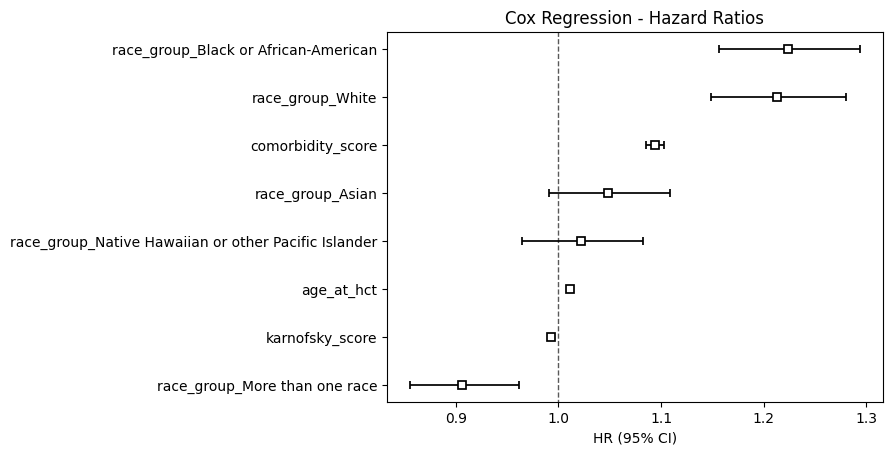

In [13]:
# Visualize the coefficients (hazard ratios)
cph.plot(hazard_ratios=True)
plt.title("Cox Regression - Hazard Ratios")
plt.show()

# **Survival Curves for Comorbidity Score**

The survival curves generated by the **Cox Proportional Hazards (CPH)** model illustrate the relationship between comorbidity score and survival probabilities over time. The x-axis represents time (e.g., in months), while the y-axis shows the probability of survival. Each line corresponds to a specific comorbidity score, ranging from 0 (no comorbidities) to 4 (high comorbidity burden), with a dashed line representing the baseline survival curve. The results indicate that higher comorbidity scores are associated with lower survival probabilities, as reflected by the descending order of the survival curves. Patients with a comorbidity score of 0 exhibit the highest survival probabilities, while those with a score of 4 experience the steepest decline and the lowest overall survival.

All survival curves show a steep decline during the early months, reflecting a high-risk period immediately after the transplant. This decline is more pronounced for patients with higher comorbidity scores, indicating that comorbidities significantly exacerbate early post-transplant risks. Beyond the initial phase, the survival curves stabilize, but patients with higher comorbidity scores continue to have significantly lower survival probabilities compared to those with lower scores. The persistent gap between the survival curves suggests that comorbidities have a lasting impact on survival outcomes. The baseline survival curve aligns closely with a mid-range comorbidity score, representing an "average" patient in the population.

These findings highlight the clinical importance of managing comorbidities before and after transplantation. Higher comorbidity scores predict worse survival outcomes, emphasizing the need for targeted interventions and closer monitoring for high-risk patients, particularly during the early post-transplant phase. Even long-term outcomes are worse for patients with higher scores, indicating the necessity of sustained care. This analysis also underscores the potential for risk stratification, where patients can be categorized by comorbidity scores to prioritize resources and tailor interventions.

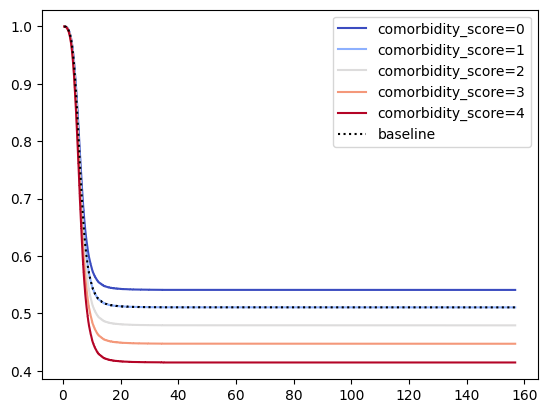

In [14]:
cph.plot_partial_effects_on_outcome(covariates='comorbidity_score', values=[0, 1, 2, 3, 4], cmap='coolwarm');

# **XGBoost Model For Survival**

We will now use an **XGBoost** model with **Optuna** to find the ideal hyperparameters. This model will be used to submit predictions.

This **XGBoost** model implements survival analysis using the Cox proportional hazards (CPH) loss function, a widely used approach for time-to-event modeling. It predicts risk scores for patients undergoing hematopoietic cell transplantation (HCT), leveraging features such as patient demographics and clinical characteristics. The CPH model ranks patients based on their relative risk of experiencing an event, such as death or relapse. It evaluates performance using metrics like the concordance index (C-index), which measures the model’s ability to rank patients by their predicted risk correctly.

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import optuna

# Load the data
train_path = "/kaggle/input/equity-post-HCT-survival-predictions/train.csv"
data_dict = "/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv"

train_df = pd.read_csv(train_path)
data_info_df = pd.read_csv(data_dict)

# Preprocessing
epsilon = 1e-5
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for index, row in data_info_df.iterrows():
    if row["type"] == "Categorical":
        train_df[row["variable"]] = label_encoder.fit_transform(train_df[row["variable"]].astype(str))
    else:
        train_df[row["variable"]] = train_df[row["variable"]].fillna(-1)
        
# Define target variable
train_df["y"] = train_df["efs"] / (train_df["efs_time"] + epsilon)

# Define features and target
X = train_df.drop(columns=["efs", "efs_time", "ID", "y"])
y = train_df["y"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna objective function
def objective(trial):
    # Hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-5, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-5, 1.0, log=True),
        "early_stopping_rounds": 50  # Move early stopping here
    }

    # Train the model
    model = XGBRegressor(random_state=42, **params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    # Predictions and evaluation
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best parameters and RMSE
print("Best parameters:", study.best_params)
print("Best RMSE:", study.best_value)

# Train the final model with the best parameters
best_params = study.best_params
final_model = XGBRegressor(random_state=42, **best_params)
final_model.fit(X_train, y_train)

# Final predictions and evaluation
y_pred = final_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Final RMSE: {rmse:.4f}")
print(f"Final MAE: {mae:.4f}")
print(f"Final R²: {r2:.4f}")

[I 2024-12-13 19:37:45,558] A new study created in memory with name: no-name-b94ed6b1-cafb-433a-a270-e2ebcd8a39e1
[I 2024-12-13 19:37:51,768] Trial 0 finished with value: 0.11354596340437421 and parameters: {'n_estimators': 1300, 'learning_rate': 0.02247638693303089, 'max_depth': 10, 'subsample': 0.6281397455162187, 'colsample_bytree': 0.8327435290274975, 'reg_alpha': 5.170347475481733e-05, 'reg_lambda': 1.3534267188920338e-05}. Best is trial 0 with value: 0.11354596340437421.
[I 2024-12-13 19:37:54,293] Trial 1 finished with value: 0.12000752505774546 and parameters: {'n_estimators': 500, 'learning_rate': 0.2831577805968312, 'max_depth': 14, 'subsample': 0.8831204240084493, 'colsample_bytree': 0.8394528985844991, 'reg_alpha': 0.21307701760478884, 'reg_lambda': 0.00095257892016781}. Best is trial 0 with value: 0.11354596340437421.
[I 2024-12-13 19:37:56,614] Trial 2 finished with value: 0.11401555800874164 and parameters: {'n_estimators': 1500, 'learning_rate': 0.04291546592833156, 'ma

Best parameters: {'n_estimators': 1600, 'learning_rate': 0.01905179103092752, 'max_depth': 4, 'subsample': 0.8812474233495814, 'colsample_bytree': 0.7327323463049218, 'reg_alpha': 0.0004303535893825314, 'reg_lambda': 0.05062380035179936}
Best RMSE: 0.11232839443705515
Final RMSE: 0.1123
Final MAE: 0.0831
Final R²: 0.1837


In [16]:
from lifelines.utils import concordance_index

# Define the score function
def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Calculate C-index for each race group and return the global score.
    """
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ValueError(f'Submission column {col} must be a number')

    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list) - np.sqrt(np.var(metric_list)))

# Final predictions
y_pred = final_model.predict(X_test)

# Prepare DataFrames for scoring
y_true_df = train_df.iloc[X_test.index][["ID", "efs", "efs_time", "race_group"]].copy()
y_pred_df = train_df.iloc[X_test.index][["ID"]].copy()
y_pred_df["prediction"] = y_pred

# Calculate the stratified C-index
stratified_c_index = score(y_true_df, y_pred_df, "ID")
print(f"Stratified C-index: {stratified_c_index:.4f}")

Stratified C-index: 0.6716


In [17]:
import optuna.visualization as vis

# Plot optimization history (objective value per trial)
fig = vis.plot_optimization_history(study)
fig.show()

# **SHAP (SHapley Additive exPlanations)**

SHAP (SHapley Additive exPlanations) is a unified framework for interpreting machine learning models. It is based on cooperative game theory and provides insights into the contribution of each feature to a model's predictions.

---

**Key Concepts**

1. **Shapley Values**:
   - Originating from cooperative game theory, Shapley values quantify the contribution of each feature to the prediction by considering all possible combinations of features.
   - SHAP adapts Shapley values for machine learning models to explain predictions.

2. **Additive Feature Attribution**:
   - SHAP assumes a model's output can be expressed as the sum of contributions from individual features:
   $$
   f(x) = \phi_0 + \sum_{i=1}^{M} \phi_i
   $$
   - Where:
     - $f(x)$: Model output for input $ x $.
     - $phi_0$: Baseline prediction (average model output for the dataset).
     - $phi_i$: Contribution of feature $ i $ to the prediction.

---

**How SHAP Works**

1. **Baseline Value** ($ \phi_0 $):
   - Represents the average model prediction if no features are present.

2. **Feature Contributions** ($ \phi_i $):
   - Quantifies the impact of each feature on moving the prediction away from the baseline.

---

**Types of SHAP Visualizations**

1. **Summary Plot (Bar Plot)**:
   - Shows all features' mean absolute SHAP values, indicating overall feature importance.
   - Features are ranked by importance.

2. **Summary Plot (Beeswarm Plot)**:
   - Displays the distribution of SHAP values for each feature across all predictions.
   - Highlights feature interaction and variability.

3. **Force Plot**:
   - Visualizes feature contributions for individual predictions.
   - Shows how features push the prediction above or below the baseline.

4. **Dependence Plot**:
   - Shows the relationship between a single feature's SHAP value and the feature's actual value, revealing non-linear dependencies.

---

**Why Use SHAP?**

- **Model-Agnostic**:
  - Works with any machine learning model, including tree-based models like XGBoost, LightGBM, CatBoost, and deep learning models.
  
- **Consistent and Fair**:
  - Provides consistent feature attributions based on Shapley theory.
  
- **Interpretable**:
  - Enables understanding of model predictions at both global and local levels.

---

**Common Use Cases**

1. **Feature Importance**:
   - Understand which features contribute most to the model's predictions.

2. **Individual Prediction Explanation**:
   - Explain why a specific prediction was made.

3. **Feature Interaction**:
   - Explore how features interact and influence predictions.

---

**Formulas**

### **Shapley Value for Feature $ i $**:
$$
\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|! (|N| - |S| - 1)!}{|N|!} \big( f(S \cup \{i\}) - f(S) \big)
$$

Where:
- $ S $: Subset of features excluding $ i $.
- $ N $: Set of all features.
- $ f(S) $: Model prediction using subset $ S $ of features.
- $ \phi_i $: Contribution of feature $ i $.

### **Model Prediction**:
$$
\hat{y} = \phi_0 + \sum_{i=1}^{n} \phi_i
$$

Where:
- $ \phi_0 $: Baseline prediction (average of all predictions).
- $ \phi_i $: Shapley value for feature $ i $.
- $ \hat{y} $: Model prediction for a specific instance.

---

**SHAP in Practice**

1. **Explaining Predictions**:
   - SHAP can help identify why a model predicts a certain outcome, making it useful in healthcare, finance, and marketing domains.

2. **Debugging Models**:
   - SHAP can reveal unexpected feature impacts, helping to debug and improve models.

---

**References**

- Lundberg, S. M., & Lee, S.-I. (2017). A Unified Approach to Interpreting Model Predictions. _Advances in Neural Information Processing Systems (NIPS)_.
- SHAP Official Documentation: [https://shap.readthedocs.io](https://shap.readthedocs.io)


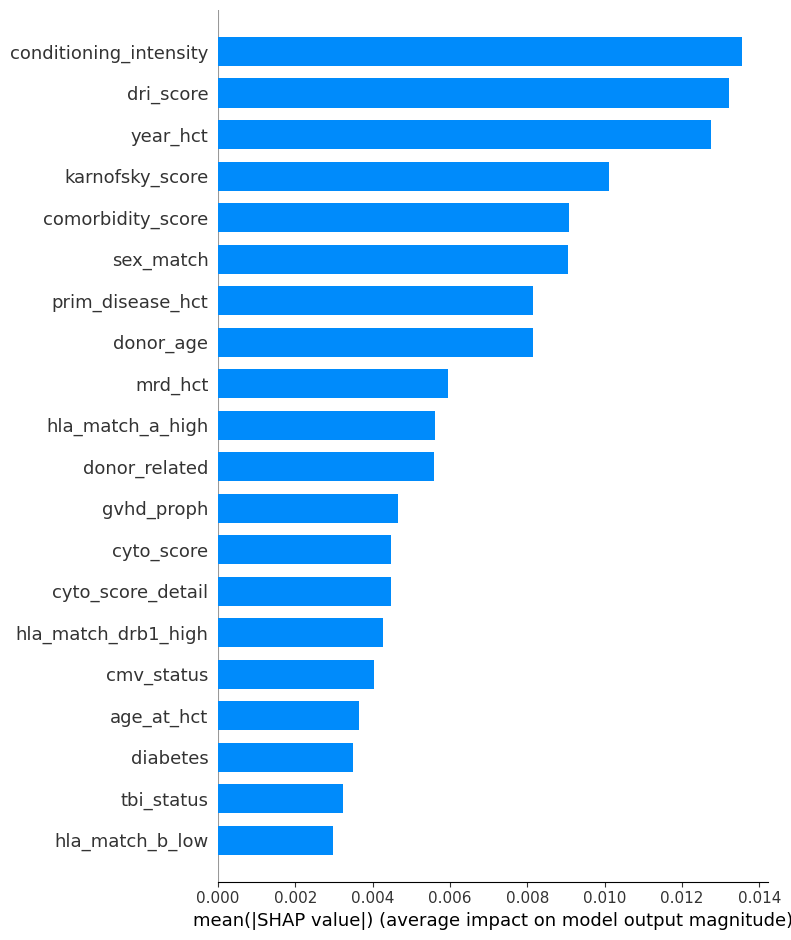

In [18]:
import shap
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Use only the first 100 rows of X
X = X.iloc[:100, :]

# Clean feature names by replacing special characters
X.columns = (
    X.columns.str.replace(r"\[", "_", regex=True)
             .str.replace(r"\]", "_", regex=True)
             .str.replace(r"<", "_", regex=True)
)

# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(final_model)  # Use TreeExplainer with the XGBoost model

# Compute SHAP values for all rows at once
shap_values = explainer.shap_values(X)

# Summary plot: Displays the importance of features
shap.summary_plot(shap_values, X, plot_type="bar")  # Bar plot of mean absolute SHAP values

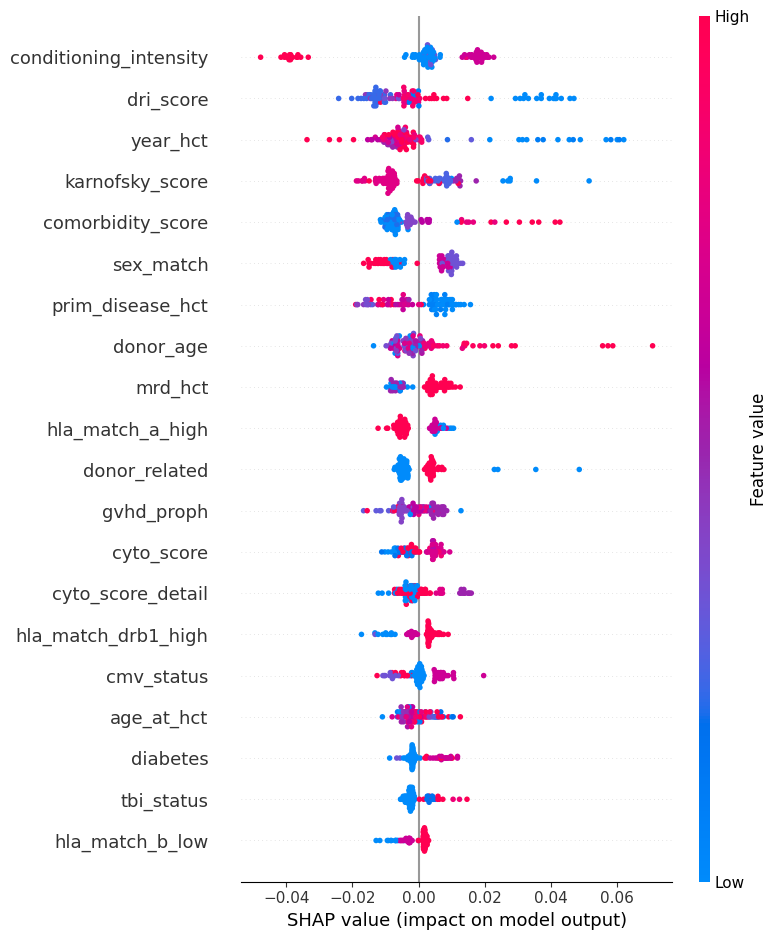

In [19]:
# Summary plot: Detailed distribution of feature impacts
shap.summary_plot(shap_values, X)  # Beeswarm plot

# **Create Submission CSV**

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

# Load the test and sample submission files
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
sample_submission = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv')

# Load the training data for consistent preprocessing
train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')

# Preprocessing: Handle categorical and numerical variables consistently
label_encoder = LabelEncoder()

for column in train.columns:
    if column in ["efs", "efs_time"]:  # Skip target variables not present in the test set
        continue
    
    if train[column].dtype == 'object':  # Handle categorical variables
        test[column] = test[column].fillna("NAN")
        train[column] = train[column].fillna("NAN")
        label_encoder.fit(pd.concat([train[column], test[column]], axis=0))
        test[column] = label_encoder.transform(test[column])
    else:  # Handle numerical variables
        test[column] = test[column].fillna(-1)  # Replace missing values with -1

# Define features to align with the training data
FEATURES = [col for col in train.columns if col not in ["ID", "efs", "efs_time", "y"]]

# Ensure the test set matches the feature space of the training data
missing_cols = [col for col in FEATURES if col not in test.columns]
for col in missing_cols:
    test[col] = 0  # Add missing columns with default values

test = test[FEATURES]  # Reorder columns to match the training feature space

# Make predictions on the test set
test['predicted_risk'] = final_model.predict(test)

# Prepare the submission file
sample_submission['prediction'] = test['predicted_risk']

# Check for any missing or invalid values in the predictions
if sample_submission['prediction'].isnull().any():
    raise ValueError("The submission file contains NaN values. Please check your predictions.")

# Save the submission file in the correct format
sample_submission.to_csv('submission.csv', index=False)

# Display the first few rows of the submission file to verify
sample_submission.head()

,ID,prediction
0,28800,0.200482
1,28801,0.192543
2,28802,0.143146
